# References

[Logistic Regression on MNIST](https://towardsdatascience.com/logistic-regression-on-mnist-with-pytorch-b048327f8d19)

# (1) Load the required packages


In [ ]:
!pip install foolbox

     |████████████████████████████████| 1.7MB 15.9MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 163kB 56.3MB/s 
     |████████████████████████████████| 71kB 11.6MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import time
import torch.nn as nn
import numpy as np
from foolbox import PyTorchModel, accuracy, samples, plot, criteria, distances
import foolbox.attacks as fa
import torchvision.models as models
import eagerpy as ep
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# (2) Setup the Logistic Regression model

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, num_classes)
        
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        out = self.linear(x)
        return out

# (3) Train the model

## (3a) Prepare the MNIST dataset

In [ ]:
batch_size = 100

train_dataset = datasets.MNIST(root='.',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True,
                              )
test_dataset = datasets.MNIST(root='.',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True,
                              )

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                         )
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                        )



Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## (3b) Train the model

In [ ]:
input_size = 784
num_classes = 10
num_epochs = 25
lr = 0.001

In [ ]:
logReg_model = LogisticRegression(input_size, num_classes).to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(logReg_model.parameters(), lr=lr)

In [ ]:
itr = 0
report_req = 100
for epoch in range(num_epochs):
    for (images, labels) in train_loader:
        images = images.reshape(-1, input_size).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = logReg_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if itr % report_req == 0:
            print(f'Epoch: {epoch+1}; Step: {itr+1}; Loss: {loss:.5f}')
            
        itr += 1

Epoch: 1; Step: 1; Loss: 2.28418
Epoch: 1; Step: 101; Loss: 2.17068
Epoch: 1; Step: 201; Loss: 2.06963
Epoch: 1; Step: 301; Loss: 1.98742
Epoch: 1; Step: 401; Loss: 1.89028
Epoch: 1; Step: 501; Loss: 1.88330
Epoch: 2; Step: 601; Loss: 1.75872
Epoch: 2; Step: 701; Loss: 1.66753
Epoch: 2; Step: 801; Loss: 1.62527
Epoch: 2; Step: 901; Loss: 1.55158
Epoch: 2; Step: 1001; Loss: 1.58879
Epoch: 2; Step: 1101; Loss: 1.48389
Epoch: 3; Step: 1201; Loss: 1.40023
Epoch: 3; Step: 1301; Loss: 1.41532
Epoch: 3; Step: 1401; Loss: 1.33365
Epoch: 3; Step: 1501; Loss: 1.28935
Epoch: 3; Step: 1601; Loss: 1.22924
Epoch: 3; Step: 1701; Loss: 1.15335
Epoch: 4; Step: 1801; Loss: 1.18401
Epoch: 4; Step: 1901; Loss: 1.14914
Epoch: 4; Step: 2001; Loss: 1.17814
Epoch: 4; Step: 2101; Loss: 1.13603
Epoch: 4; Step: 2201; Loss: 1.18859
Epoch: 4; Step: 2301; Loss: 0.99883
Epoch: 5; Step: 2401; Loss: 1.10732
Epoch: 5; Step: 2501; Loss: 1.03669
Epoch: 5; Step: 2601; Loss: 1.01524
Epoch: 5; Step: 2701; Loss: 0.96023
Epoc

## (3c) Test the model

In [ ]:
correct = 0
total = 0
for (images, labels) in test_loader:
    images = images.reshape(-1, input_size).to(device)
    labels = labels.to(device)

    outputs = logReg_model(images)

    predicted = torch.argmax(outputs, 1)
    
    correct += torch.sum(predicted==labels)
    total += labels.shape[0]

acc = correct / total * 100
print(f'Final accuracy is: {acc:.2f}%')

Final accuracy is: 87.80%


# (4) Perform the attack

## (4a) Helper functions

In [ ]:
def plot_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(24, 24))

    for i, ax in enumerate(axs.flat):
        image = images[i]
        image = np.squeeze(image, axis=0)
        ax.matshow(image)
        ax.axis('off')
        ax.set_title(f'Image {i}')

    fig.show()

## (4b) Setup the PyTorchModel and do a simple test

labels     :  [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]
predictions:  [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]
clean accuracy:  95.0 %



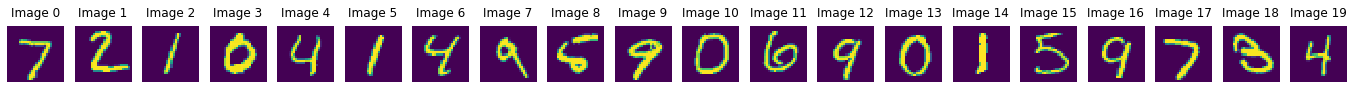

In [ ]:
model = logReg_model.eval()
fmodel = PyTorchModel(model, bounds=(0, 1))
batch_size = 20
images, labels = samples(fmodel, dataset="mnist", batchsize=20)

clean_acc = accuracy(fmodel, images, labels)
predictions = fmodel(images).argmax(-1)
plot_images(images.cpu().numpy())
print("labels     : ", [l for l in labels.cpu().numpy()])
print("predictions: ", [l for l in predictions.cpu().numpy()])

print(f"clean accuracy:  {clean_acc * 100:.1f} %")
print("")

## (4c) Start the actual attack

epsilons
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.95 0.95 0.95 0.9  0.9  0.85 0.85 0.85 0.85 0.75 0.75]
Time taken:  0.0027759552001953127 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.95 0.45 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
Time taken:  0.000560295581817627 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.95 0.95 0.95 0.9  0.9  0.85 0.85 0.85 0.8  0.75 0.75]
Time taken:  0.03275783061981201 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.95 0.45 0.05 0.   0.   0.   0. 

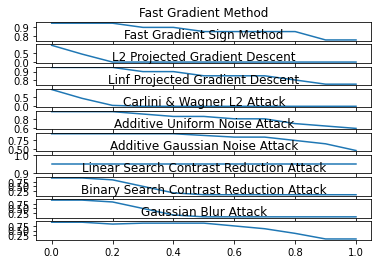

In [ ]:
%matplotlib inline

attacks = [
           # gradient-based attacks
           {"name": "Fast Gradient Method", "model": fa.L2FastGradientAttack()},
           {"name": "Fast Gradient Sign Method", "model": fa.LinfFastGradientAttack()},
           {"name": "L2 Projected Gradient Descent", "model": fa.L2ProjectedGradientDescentAttack()},
           {"name": "Linf Projected Gradient Descent", "model": fa.LinfProjectedGradientDescentAttack()},
           {"name": "Carlini & Wagner L2 Attack", "model": fa.L2CarliniWagnerAttack()},
           # decision-based attacks
        #    {"name": "Boundary Attack", "model": fa.BoundaryAttack()},
           {"name": "Additive Uniform Noise Attack", "model": fa.LinfAdditiveUniformNoiseAttack()},
           {"name": "Additive Gaussian Noise Attack", "model": fa.L2AdditiveGaussianNoiseAttack()},
           {"name": "Linear Search Contrast Reduction Attack", "model": fa.LinearSearchContrastReductionAttack(distance=distances.linf)},
           {"name": "Binary Search Contrast Reduction Attack", "model": fa.BinarySearchContrastReductionAttack(distance=distances.linf)},
           {"name": "Gaussian Blur Attack", "model": fa.GaussianBlurAttack(distance=distances.linf)},
]
    
epsilons = [
        0.0,
        0.1,
        0.2,
        0.3,
        0.4,
        0.5,
        0.6,
        0.7,
        0.8,
        0.9,
        1.0,
    ]
print("epsilons")
print(epsilons)
print("")

attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=np.bool)
fig, axs = plt.subplots(len(attacks))
fig.tight_layout()
for i, attack in enumerate(attacks):
    # plot_images(images.cpu().numpy())
    # The raw adversarial examples. This depends on the attack and we cannot make an guarantees about this output.
    # The clipped adversarial examples. These are guaranteed to not be perturbed more than epsilon and thus are the actual adversarial examples you want to visualize. Note that some of them might not actually switch the class. To know which samples are actually adversarial, you should look at the third tensor.
    # The third tensor contains a boolean for each sample, indicating which samples are true adversarials that are both misclassified and within the epsilon balls around the clean samples.
    t1 = time.time()
    raw_adv, clipped_adv, is_adv = attack["model"](fmodel, images, labels, epsilons=epsilons)
    t2 = time.time()
    success_ = is_adv.cpu().numpy()
    attack_success[i] = success_
    print(attack)
    print("  ", 1.0 - success_.mean(axis=-1).round(2))
    print("Time taken: ", (t2 - t1) / batch_size, "seconds")

    # plot the robust accuracy against epsilons for the particular attack
    robust_accuracy = 1 - is_adv.float().mean(axis=-1)
    axs[i].plot(epsilons, robust_accuracy.cpu().numpy())
    axs[i].set_title(attack["name"])
    # axs.plot(epsilons, robust_accuracy.cpu().numpy())
    # axs.set_title(attack["name"])

    print("Clipped adversaries: ")
    # plot_images(clipped_adv[0].cpu().numpy())


## (4d) Print the best attack per sample

In [ ]:
# calculate and report the robust accuracy (the accuracy of the model when
# it is attacked) using the best attack per sample
robust_accuracy = 1.0 - attack_success.max(axis=0).mean(axis=-1)
print("")
print("-" * 79)
print("")
print("worst case (best attack per-sample)")
print("  ", robust_accuracy.round(2))
print("")

print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")


-------------------------------------------------------------------------------

worst case (best attack per-sample)
   [0.95 0.45 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]

robust accuracy for perturbations with
  Linf norm ≤ 0.0   : 95.0 %
  Linf norm ≤ 0.1   : 45.0 %
  Linf norm ≤ 0.2   :  0.0 %
  Linf norm ≤ 0.3   :  0.0 %
  Linf norm ≤ 0.4   :  0.0 %
  Linf norm ≤ 0.5   :  0.0 %
  Linf norm ≤ 0.6   :  0.0 %
  Linf norm ≤ 0.7   :  0.0 %
  Linf norm ≤ 0.8   :  0.0 %
  Linf norm ≤ 0.9   :  0.0 %
  Linf norm ≤ 1.0   :  0.0 %


## (4e) Start multiple runs

epsilons
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

Run 1 clean accuracy:  78.1 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.78 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.72 0.69 0.66]
Time taken:  0.0008964419364929199 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.78 0.38 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
Time taken:  0.0006626009941101074 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.78 0.75 0.75 0.75 0.75 0.75 0.75 0.72 0.72 0.69 0.66]
Time taken:  0.030172348022460938 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.78 0.38 0.   0.   0.   0.   0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.88 0.81 0.75 0.75 0.72 0.69 0.66 0.66 0.62 0.59 0.56]
Time taken:  0.0008822083473205566 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.88 0.47 0.03 0.   0.   0.   0.   0.   0.   0.   0.  ]
Time taken:  0.0004930615425109864 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.88 0.81 0.75 0.75 0.72 0.69 0.66 0.66 0.62 0.56 0.56]
Time taken:  0.02986658811569214 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.88 0.47 0.03 0.   0.   0.   0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.88 0.88 0.84 0.84 0.84 0.84 0.84 0.81 0.75 0.75 0.69]
Time taken:  0.0009787797927856446 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.88 0.5  0.06 0.   0.   0.   0.   0.   0.   0.   0.  ]
Time taken:  0.0005018711090087891 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.88 0.88 0.84 0.84 0.84 0.84 0.84 0.81 0.75 0.75 0.69]
Time taken:  0.03014916181564331 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.88 0.5  0.06 0.   0.   0.   0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [1.   0.97 0.97 0.97 0.97 0.94 0.88 0.88 0.81 0.81 0.75]
Time taken:  0.0008499741554260254 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [1.   0.5  0.06 0.   0.   0.   0.   0.   0.   0.   0.  ]
Time taken:  0.0005121231079101562 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [1.   0.97 0.97 0.97 0.97 0.91 0.88 0.84 0.81 0.81 0.75]
Time taken:  0.02922288179397583 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [1.   0.53 0.06 0.   0.   0.   0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.78 0.75 0.75 0.75 0.72 0.72 0.66 0.66 0.66 0.59 0.59]
Time taken:  0.0009269356727600097 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.78 0.44 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
Time taken:  0.0005196928977966309 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.78 0.75 0.75 0.75 0.72 0.69 0.66 0.66 0.66 0.59 0.59]
Time taken:  0.031686830520629886 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.78 0.44 0.   0.   0.   0.   0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.97 0.97 0.94 0.91 0.84 0.81 0.78 0.78 0.72 0.72 0.69]
Time taken:  0.0008767485618591308 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.97 0.53 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
Time taken:  0.000530862808227539 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.97 0.94 0.94 0.88 0.84 0.81 0.78 0.75 0.72 0.69 0.69]
Time taken:  0.030476200580596923 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.97 0.56 0.   0.   0.   0.   0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.88 0.84 0.81 0.81 0.81 0.81 0.81 0.75 0.75 0.69 0.69]
Time taken:  0.0008705615997314453 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.88 0.53 0.09 0.   0.   0.   0.   0.   0.   0.   0.  ]
Time taken:  0.0005178570747375489 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.88 0.84 0.81 0.81 0.81 0.81 0.81 0.75 0.72 0.69 0.66]
Time taken:  0.03212252855300903 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.88 0.56 0.09 0.   0.   0.   0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.88 0.81 0.81 0.81 0.81 0.81 0.81 0.81 0.81 0.81 0.78]
Time taken:  0.0008496642112731934 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.88 0.5  0.03 0.   0.   0.   0.   0.   0.   0.   0.  ]
Time taken:  0.0005187630653381347 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.88 0.81 0.81 0.81 0.81 0.81 0.81 0.81 0.81 0.78 0.75]
Time taken:  0.030226421356201173 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.88 0.53 0.03 0.   0.   0.   0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.88 0.84 0.81 0.78 0.75 0.75 0.72 0.69 0.69 0.66 0.62]
Time taken:  0.0008800268173217773 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.88 0.41 0.03 0.   0.   0.   0.   0.   0.   0.   0.  ]
Time taken:  0.0005377411842346191 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.88 0.84 0.81 0.75 0.75 0.75 0.72 0.69 0.66 0.66 0.62]
Time taken:  0.03055410385131836 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.88 0.44 0.06 0.   0.   0.   0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.88 0.84 0.81 0.81 0.81 0.78 0.78 0.75 0.72 0.69 0.69]
Time taken:  0.0008778810501098633 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.88 0.47 0.03 0.   0.   0.   0.   0.   0.   0.   0.  ]
Time taken:  0.0005307316780090332 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.88 0.84 0.81 0.81 0.81 0.78 0.78 0.75 0.72 0.69 0.69]
Time taken:  0.030738639831542968 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.88 0.5  0.06 0.   0.   0.   0

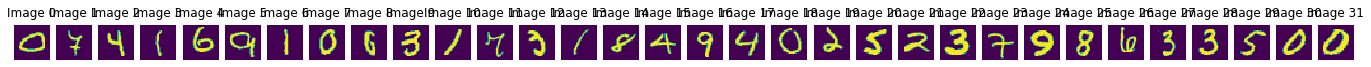

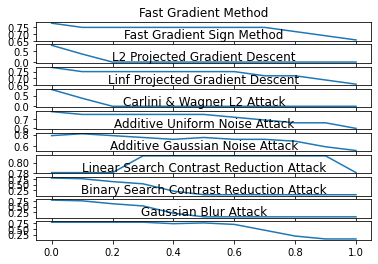

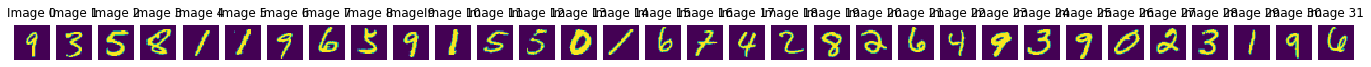

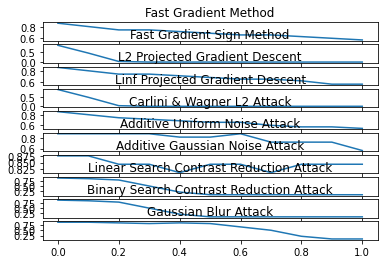

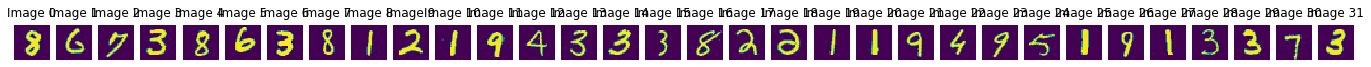

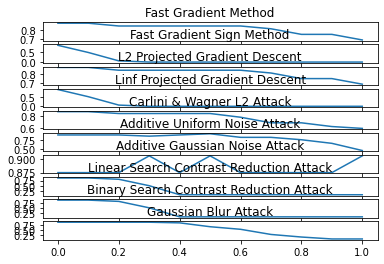

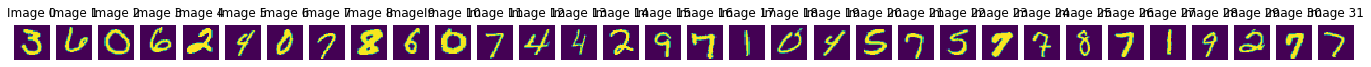

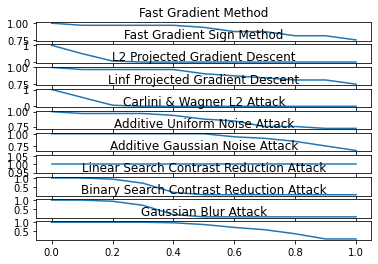

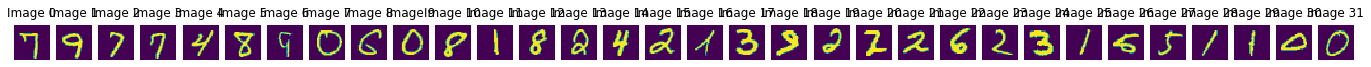

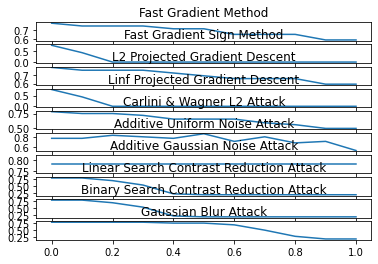

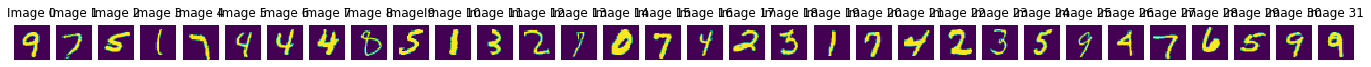

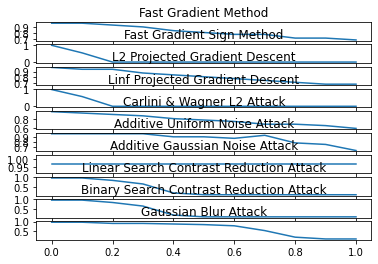

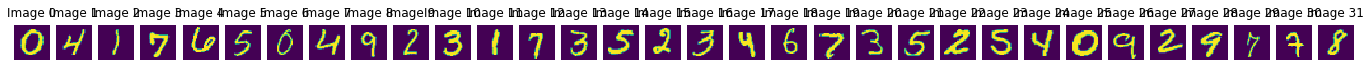

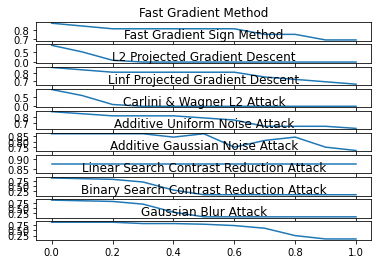

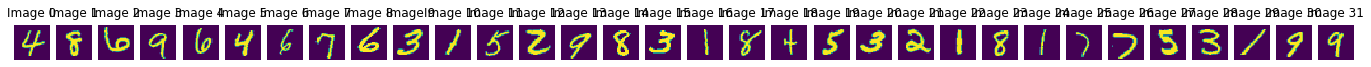

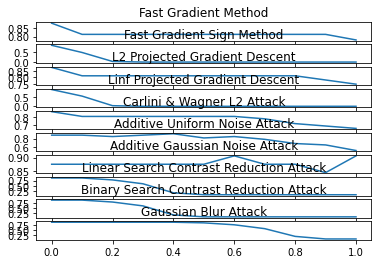

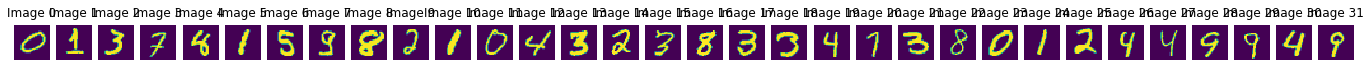

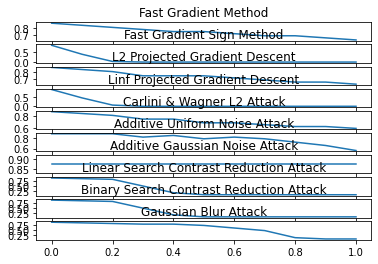

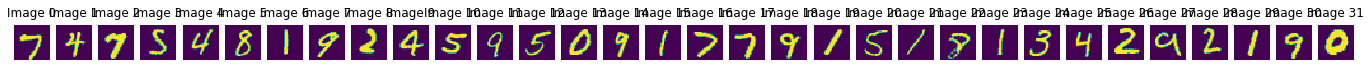

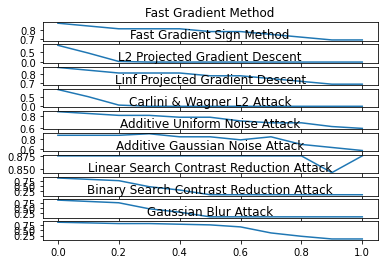

In [ ]:
testloader  = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

%matplotlib inline

attacks = [
           # gradient-based attacks
           {"name": "Fast Gradient Method", "model": fa.L2FastGradientAttack()},
           {"name": "Fast Gradient Sign Method", "model": fa.LinfFastGradientAttack()},
           {"name": "L2 Projected Gradient Descent", "model": fa.L2ProjectedGradientDescentAttack()},
           {"name": "Linf Projected Gradient Descent", "model": fa.LinfProjectedGradientDescentAttack()},
           {"name": "Carlini & Wagner L2 Attack", "model": fa.L2CarliniWagnerAttack()},
           # decision-based attacks
        #    {"name": "Boundary Attack", "model": fa.BoundaryAttack()},
           {"name": "Additive Uniform Noise Attack", "model": fa.LinfAdditiveUniformNoiseAttack()},
           {"name": "Additive Gaussian Noise Attack", "model": fa.L2AdditiveGaussianNoiseAttack()},
           {"name": "Linear Search Contrast Reduction Attack", "model": fa.LinearSearchContrastReductionAttack(distance=distances.linf)},
           {"name": "Binary Search Contrast Reduction Attack", "model": fa.BinarySearchContrastReductionAttack(distance=distances.linf)},
           {"name": "Gaussian Blur Attack", "model": fa.GaussianBlurAttack(distance=distances.linf)},
]
    
epsilons = [
        0.0,
        0.1,
        0.2,
        0.3,
        0.4,
        0.5,
        0.6,
        0.7,
        0.8,
        0.9,
        1.0,
    ]
print("epsilons")
print(epsilons)
print("")

attack_results = {}
for attack in attacks:
    attack_results[attack['name']] = []

num_of_run = 10
curr_run = 0
for (images, labels) in testloader:

    plot_images(images.cpu().numpy())

    images = images.to(device)
    labels = labels.to(device)

    images = ep.astensor(images)
    labels = ep.astensor(labels)

    clean_acc = accuracy(fmodel, images, labels)
    print(f"Run {curr_run+1} clean accuracy:  {clean_acc * 100:.1f} %")    

    attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=np.bool)
    fig, axs = plt.subplots(len(attacks))
    fig.tight_layout()
    for i, attack in enumerate(attacks):
        # plot_images(images.cpu().numpy())
        # The raw adversarial examples. This depends on the attack and we cannot make an guarantees about this output.
        # The clipped adversarial examples. These are guaranteed to not be perturbed more than epsilon and thus are the actual adversarial examples you want to visualize. Note that some of them might not actually switch the class. To know which samples are actually adversarial, you should look at the third tensor.
        # The third tensor contains a boolean for each sample, indicating which samples are true adversarials that are both misclassified and within the epsilon balls around the clean samples.
        t1 = time.time()
        raw_adv, clipped_adv, is_adv = attack["model"](fmodel, images, labels, epsilons=epsilons)
        t2 = time.time()
        success_ = is_adv.numpy()
        attack_success[i] = success_
        print(attack)
        print("  ", 1.0 - success_.mean(axis=-1).round(2))
        print("Time taken: ", (t2 - t1) / batch_size, "seconds")

        # plot the robust accuracy against epsilons for the particular attack
        robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
        axs[i].plot(epsilons, robust_accuracy.numpy())
        axs[i].set_title(attack["name"])
        # axs.plot(epsilons, robust_accuracy.cpu().numpy())
        # axs.set_title(attack["name"])

        print("Clipped adversaries: ")
        # plot_images(clipped_adv[0].cpu().numpy())

        attack_results[attack["name"]].append(robust_accuracy.numpy())

    curr_run += 1
    if curr_run >= num_of_run:
        break


## (4f) Print the average scores per attack for the multiple runs

In [ ]:
for attack_name, value in attack_results.items():
    result_list = np.asarray(value)
    avg_results = np.mean(result_list, axis=0)
    print(f'Attack: {attack_name}')
    print(f'Epsilon: {epsilons}')
    print(f'Result: {np.around(avg_results, 3)}')
    print()


Attack: Fast Gradient Method
Epsilon: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Result: [0.878 0.847 0.825 0.819 0.803 0.791 0.769 0.753 0.725 0.7   0.672]

Attack: Fast Gradient Sign Method
Epsilon: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Result: [0.878 0.472 0.034 0.    0.    0.    0.    0.    0.    0.    0.   ]

Attack: L2 Projected Gradient Descent
Epsilon: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Result: [0.878 0.844 0.825 0.812 0.803 0.784 0.769 0.744 0.719 0.691 0.666]

Attack: Linf Projected Gradient Descent
Epsilon: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Result: [0.878 0.491 0.041 0.    0.    0.    0.    0.    0.    0.    0.   ]

Attack: Carlini & Wagner L2 Attack
Epsilon: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Result: [0.878 0.844 0.822 0.806 0.784 0.762 0.738 0.678 0.659 0.631 0.6  ]

Attack: Additive Uniform Noise Attack
Epsilon: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Result: [0.

Fast Gradient Method
Fast Gradient Sign Method
L2 Projected Gradient Descent
Linf Projected Gradient Descent
Carlini & Wagner L2 Attack
Additive Uniform Noise Attack
Additive Gaussian Noise Attack
Linear Search Contrast Reduction Attack
Binary Search Contrast Reduction Attack
Gaussian Blur Attack


{'Additive Gaussian Noise Attack': [],
 'Additive Uniform Noise Attack': [],
 'Binary Search Contrast Reduction Attack': [],
 'Carlini & Wagner L2 Attack': [],
 'Fast Gradient Method': [],
 'Fast Gradient Sign Method': [],
 'Gaussian Blur Attack': [],
 'L2 Projected Gradient Descent': [],
 'Linear Search Contrast Reduction Attack': [],
 'Linf Projected Gradient Descent': []}